# Exercise III: Cart-Pole with TD(0)
>Solve the Cart-Pole control problem using TD(0) methods.


In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
#Cart-Pole Problem
env = gym.make("CartPole-v0")
env.reset()

for i in range(50000):
  action = env.action_space.sample()
  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)

  if done:
    break
    
env.close()
print("Iterations that were run:",i)

step i 0 action= 1
obs= [ 0.04381113  0.1536566  -0.03897909 -0.34188641] reward= 1.0 done= False info= {}
step i 1 action= 1
obs= [ 0.04688426  0.34931082 -0.04581682 -0.64660176] reward= 1.0 done= False info= {}
step i 2 action= 1
obs= [ 0.05387048  0.54504021 -0.05874886 -0.95335318] reward= 1.0 done= False info= {}
step i 3 action= 1
obs= [ 0.06477128  0.7409013  -0.07781592 -1.26390019] reward= 1.0 done= False info= {}
step i 4 action= 0
obs= [ 0.07958931  0.54685549 -0.10309392 -0.99656709] reward= 1.0 done= False info= {}
step i 5 action= 1
obs= [ 0.09052642  0.74319364 -0.12302527 -1.31976659] reward= 1.0 done= False info= {}
step i 6 action= 1
obs= [ 0.10539029  0.93963722 -0.1494206  -1.64828312] reward= 1.0 done= False info= {}
step i 7 action= 0
obs= [ 0.12418304  0.74654495 -0.18238626 -1.40563838] reward= 1.0 done= False info= {}
step i 8 action= 0
obs= [ 0.13911394  0.55409469 -0.21049903 -1.17507582] reward= 1.0 done= True info= {}
Iterations that were run: 8


## a. on-policy SARSA

In [6]:
#discretize the environmental feedback (S)
'''
  Type: Box(4)
  Num     Observation               Min                     Max
  0       Cart Position             -4.8                    4.8
  1       Cart Velocity             -Inf                    Inf
  2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
  3       Pole Angular Velocity     -Inf                    Inf
'''

def obs2state(obs):
    """
    Discretize observations to states
    """
    digitized = [np.searchsorted(bins, o, "right") for o, bins in zip(obs, obs2state.bin_divide)]
    return (digitized * obs2state.multiplier).sum()
obs2state.bin_divide = (
        (-2.30, +0.00, +2.30),
        (-1.00, +0.00, +1.00),
        (-0.20, +0.00, +0.20),
        (-1.00, +0.00, +1.00),
        )
obs2state.multiplier = np.concatenate([[1], np.cumprod([len(i)+1 for i in obs2state.bin_divide[:-1]])])
obs2state.S = np.product([len(i)+1 for i in obs2state.bin_divide])

In [7]:
#epsilon-greedy aglorithm, return an action 0 or 1
def choose_action(env, epsilon, state, Q):
  if np.random.random() < epsilon:
    return env.action_space.sample() 
  else:
    return np.argmax(Q[state])

In [100]:
def update(state, state2, reward, action, action2,alpha,gamma):
  Q[state, action] += alpha * (reward + gamma * Q[state2, action2] - Q[state, action])

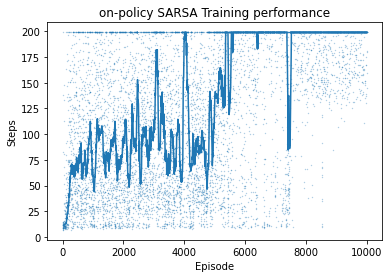

In [112]:
#on-policy sarsa
gamma = 0.999
obs = env.reset()
S = obs2state.S
A = env.action_space.n
#initialize Q, for all states Q = 0
Q = np.zeros([S,A])
steps = np.zeros(10000)

for episode in range(10000):
  epsilon = 0.1 - 0.099/10000 * episode
  alpha = 0.2 - 0.19/10000 * episode
  obs = env.reset()
  state = obs2state(obs)
  action = choose_action(env,epsilon,state,Q)

  for i in range(5000):
    obs, reward, done, info = env.step(action)
    state_ = obs2state(obs)
    action_ = choose_action(env,epsilon,state_,Q)
    update(state, state_, reward, action, action_, alpha, gamma)
    state = state_
    action = action_
    if done:
      steps[episode] = i
      break

env.close()

plt.scatter(range(len(steps)),steps, s=0.1, alpha=0.5)
plt.plot(range(len(steps)), pd.Series(steps).rolling(100).median())
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("on-policy SARSA Training performance")
plt.show()

In [119]:
#test
print("testing:")
for episode in range(10):
  obs = env.reset()

  for i in range(5000):
    state = obs2state(obs)
    action = np.argmax(Q[state])
    obs, reward, done, info = env.step(action)
    if done:
      print(f"Episode {episode} lasted {i} steps")
      break
    
  env.close()

testing:
Episode 0 lasted 199 steps
Episode 1 lasted 199 steps
Episode 2 lasted 199 steps
Episode 3 lasted 199 steps
Episode 4 lasted 199 steps
Episode 5 lasted 199 steps
Episode 6 lasted 199 steps
Episode 7 lasted 199 steps
Episode 8 lasted 177 steps
Episode 9 lasted 199 steps


## b. off-policy Q learning

In [120]:
def update(state, state2, reward, action,alpha,gamma):
  Q[state, action] += alpha * (reward + gamma * np.max(Q[state2]) - Q[state, action])

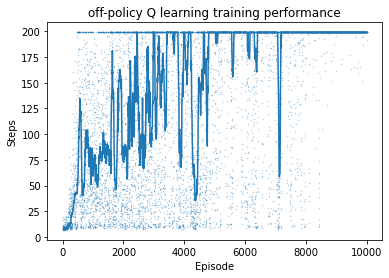

In [121]:
#off-policy Q learning
gamma = 0.999
obs = env.reset()
S = obs2state.S
A = env.action_space.n
#initialize Q, for all states Q = 0
Q = np.zeros([S,A])
steps = np.zeros(10000)

for episode in range(10000):
  epsilon = 0.1 - 0.099/10000 * episode
  alpha = 0.2 - 0.19/10000 * episode
  obs = env.reset()
  state = obs2state(obs)

  for i in range(5000):
    action = choose_action(env,epsilon,state,Q)
    obs, reward, done, info = env.step(action)
    state_ = obs2state(obs)
    update(state, state_, reward, action, alpha, gamma)
    state = state_
    if done:
      steps[episode] = i
      break

env.close()

plt.scatter(range(len(steps)),steps, s=0.1, alpha=0.5)
plt.plot(range(len(steps)), pd.Series(steps).rolling(100).median())
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("off-policy Q learning training performance")
plt.show()

In [122]:
#test
print("testing:")
for episode in range(10):
  obs = env.reset()

  for i in range(5000):
    state = obs2state(obs)
    action = np.argmax(Q[state])
    obs, reward, done, info = env.step(action)
    if done:
      print(f"Episode {episode} lasted {i} steps")
      break
    
  env.close()

testing:
Episode 0 lasted 199 steps
Episode 1 lasted 199 steps
Episode 2 lasted 199 steps
Episode 3 lasted 199 steps
Episode 4 lasted 199 steps
Episode 5 lasted 199 steps
Episode 6 lasted 199 steps
Episode 7 lasted 199 steps
Episode 8 lasted 199 steps
Episode 9 lasted 199 steps


## c. off-policy Expected SARSA with an epsilon-greedy policy

In [8]:
def update(prev_state, next_state, reward, prev_action, next_action,gamma,alpha,epsilon):
  expected_q = 0
  q_max = np.max(Q[next_state])
  greedy_actions = 0
  for i in range(Q.shape[1]):
    if Q[next_state][i] == q_max:
      greedy_actions += 1
     
  non_greedy_action_probability = epsilon / Q.shape[1]
  greedy_action_probability = ((1 - epsilon) / greedy_actions) + non_greedy_action_probability
 
  for i in range(Q.shape[1]):
    if Q[next_state][i] == q_max:
      expected_q += Q[next_state][i] * greedy_action_probability
    else:
      expected_q += Q[next_state][i] * non_greedy_action_probability
 
  Q[prev_state, prev_action] += alpha * (reward + gamma * expected_q - Q[prev_state, prev_action])

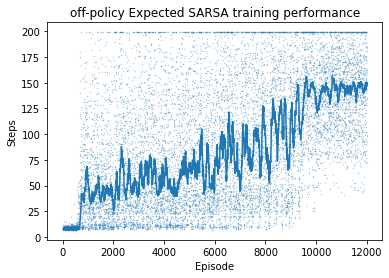

In [60]:
#off-policy Expected SARSA
gamma = 0.9999
obs = env.reset()
S = obs2state.S
A = env.action_space.n
#initialize Q, for all states Q = 0
Q = np.zeros([S,A])
steps = np.zeros(12000)

for episode in range(12000):
  epsilon = max(0.1 - 0.099/10000 * episode,0.001)
  alpha = max(0.2 - 0.199/10000 * episode,0.001)
  obs = env.reset()
  state = obs2state(obs)
  action = choose_action(env,epsilon,state,Q)

  for i in range(5000):
    obs, reward, done, info = env.step(action)
    state_ = obs2state(obs)
    action_ = choose_action(env,epsilon,state,Q)
    update(state, state_, reward, action, action_,gamma,alpha,epsilon)
    state = state_
    action = action_
    if done:
      steps[episode] = i
      break

env.close()

plt.scatter(range(len(steps)),steps, s=0.1, alpha=0.5)
plt.plot(range(len(steps)), pd.Series(steps).rolling(100).median())
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("off-policy Expected SARSA training performance")
plt.show()

In [67]:
#test
print("testing:")
for episode in range(10):
  obs = env.reset()

  for i in range(5000):
    state = obs2state(obs)
    action = np.argmax(Q[state])
    obs, reward, done, info = env.step(action)
    if done:
      print(f"Episode {episode} lasted {i} steps")
      break
    
  env.close()

testing:
Episode 0 lasted 199 steps
Episode 1 lasted 199 steps
Episode 2 lasted 199 steps
Episode 3 lasted 199 steps
Episode 4 lasted 199 steps
Episode 5 lasted 199 steps
Episode 6 lasted 164 steps
Episode 7 lasted 199 steps
Episode 8 lasted 161 steps
Episode 9 lasted 199 steps
